Invasive_Tumor: 61826 image(s) found
DCIS_1: 12925 image(s) found
DCIS_2: 11719 image(s) found
Prolif_Invasive_Tumor: 3775 image(s) found
CD4+_T_Cells: 8453 image(s) found
CD8+_T_Cells: 6941 image(s) found
B_Cells: 4987 image(s) found
Stromal: 41424 image(s) found
Epoch 1/20
118/118 [==============================] - 63s 519ms/step - loss: 1.3838 - accuracy: 0.4101 - val_loss: 1.1790 - val_accuracy: 0.5389
Epoch 2/20
118/118 [==============================] - 89s 749ms/step - loss: 1.1523 - accuracy: 0.5423 - val_loss: 1.0272 - val_accuracy: 0.5969
Epoch 3/20
118/118 [==============================] - 62s 518ms/step - loss: 1.0055 - accuracy: 0.6017 - val_loss: 0.9568 - val_accuracy: 0.6279
Epoch 4/20
118/118 [==============================] - 51s 424ms/step - loss: 0.9382 - accuracy: 0.6359 - val_loss: 0.8868 - val_accuracy: 0.6533
Epoch 5/20
118/118 [==============================] - 52s 431ms/step - loss: 0.8889 - accuracy: 0.6568 - val_loss: 0.9221 - val_accuracy: 0.6284
Epoch 6/20

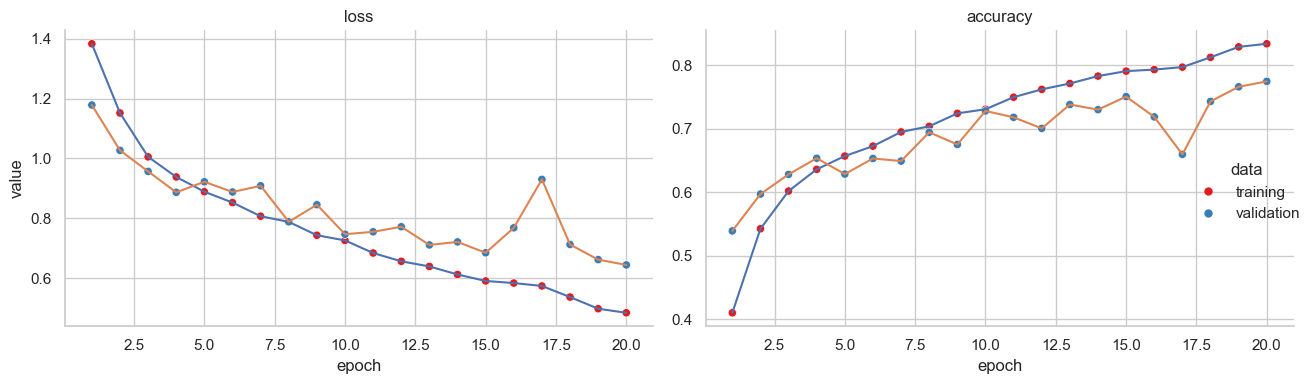

30/30 [==============================] - 10s 316ms/step
                       precision    recall  f1-score   support

         Immune_Cells       0.84      0.90      0.87      3000
       Invasive_Tumor       0.83      0.58      0.69      3000
               DCIS_1       0.80      0.83      0.82      3000
               DCIS_2       0.69      0.71      0.70      3000
Prolif_Invasive_Tumor       0.73      0.85      0.79      3000

             accuracy                           0.77     15000
            macro avg       0.78      0.77      0.77     15000
         weighted avg       0.78      0.77      0.77     15000



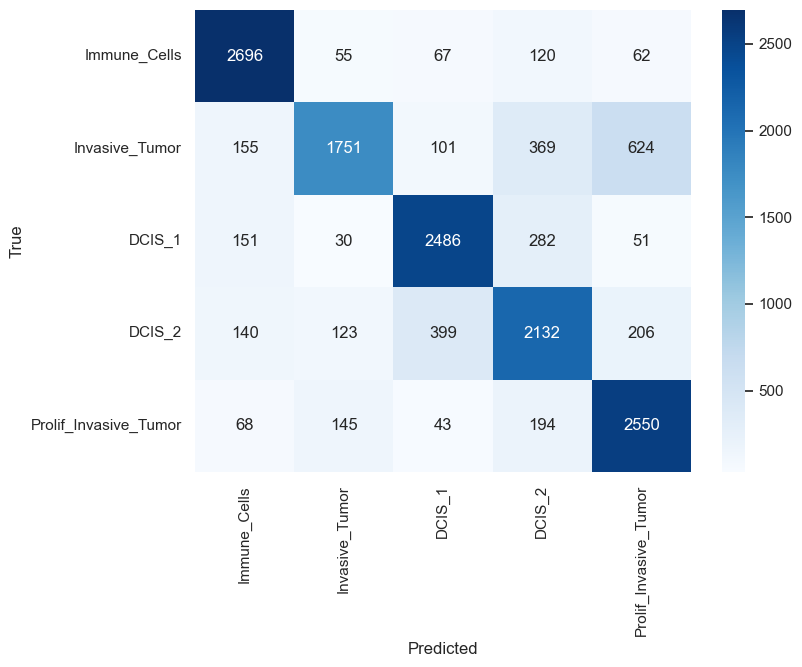

30/30 [==============================] - 34s 1s/step


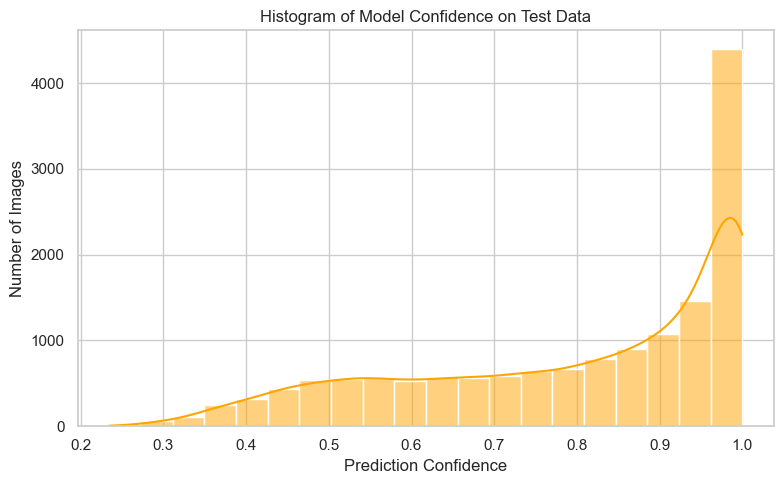

1/1 [==============================] - 0s 212ms/step

--- Unseen Data Evaluation ---
                       precision    recall  f1-score   support

         Immune_Cells       0.70      0.92      0.79        25
       Invasive_Tumor       0.68      0.52      0.59        25
               DCIS_1       0.72      0.72      0.72        25
               DCIS_2       0.55      0.64      0.59        25
Prolif_Invasive_Tumor       0.58      0.44      0.50        25

             accuracy                           0.65       125
            macro avg       0.65      0.65      0.64       125
         weighted avg       0.65      0.65      0.64       125



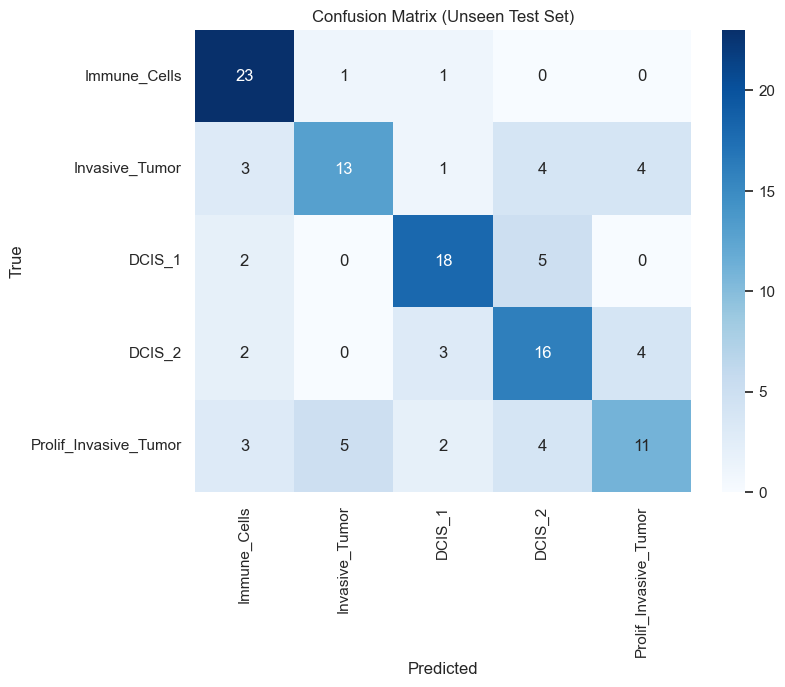

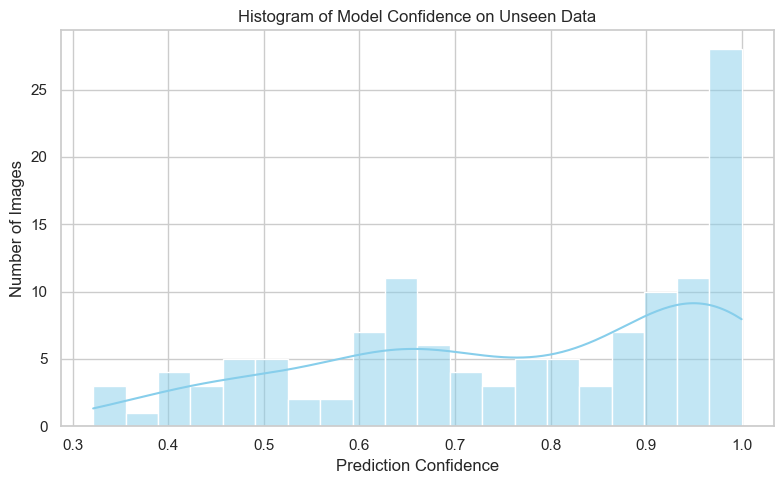

In [5]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
import cv2

seed = 3888
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

img_width, img_height = 50, 50
batch_size = 512
AUTOTUNE = tf.data.AUTOTUNE

tumor_folders = ["Invasive_Tumor", "DCIS_1", "DCIS_2", "Prolif_Invasive_Tumor"]
immune_folders = ["CD4+_T_Cells", "CD8+_T_Cells", "B_Cells", "Stromal"]

for folder in tumor_folders + immune_folders:
    files = tf.io.gfile.glob(os.path.join(folder, "*.png"))
    print(f"{folder}: {len(files)} image(s) found")

def get_file_label_pairs(folders, main_label):
    pairs = []
    for folder in folders:
        files = tf.io.gfile.glob(os.path.join(folder, "*.png"))
        for f in files:
            sub_label = os.path.basename(folder)
            pairs.append((f, main_label, sub_label))
    return pairs

tumor_files = get_file_label_pairs(tumor_folders, main_label=1)
immune_files = get_file_label_pairs(immune_folders, main_label=0)
all_file_label_pairs = tumor_files + immune_files



# --- Define unseen set ---
target_size = 15000
unseen_size = 200

def get_balanced_unseen_set(file_label_pairs, tumor_per_class=25, total_immune_samples=25):
    class_to_files = defaultdict(list)
    for f, main_label, sub_label in file_label_pairs:
        class_to_files[sub_label].append((f, main_label, sub_label))

    unseen_set = []

    # Tumor classes – get 25 from each
    tumor_classes = ["Invasive_Tumor", "DCIS_1", "DCIS_2", "Prolif_Invasive_Tumor"]
    for sub_label in tumor_classes:
        files = class_to_files[sub_label]
        if len(files) < tumor_per_class:
            raise ValueError(f"Not enough samples in class '{sub_label}' to select {tumor_per_class}")
        selected = random.sample(files, tumor_per_class)
        unseen_set.extend((f, m, s, False) for f, m, s in selected)

    # Immune classes – randomly pick 25 from all immune types combined
    immune_classes = ["CD4+_T_Cells", "CD8+_T_Cells", "B_Cells", "Stromal"]
    all_immune_files = []
    for sub_label in immune_classes:
        all_immune_files.extend(class_to_files[sub_label])
     
    if len(all_immune_files) < total_immune_samples:
        raise ValueError(f"Not enough total immune samples to select {total_immune_samples}")
    selected_immune = random.sample(all_immune_files, total_immune_samples)
    unseen_set.extend((f, m, s, False) for f, m, s in selected_immune)

    random.shuffle(unseen_set)
    return unseen_set


# Create unseen set and filter it out
unseen_pairs = get_balanced_unseen_set(all_file_label_pairs, tumor_per_class=25, total_immune_samples=25)

unseen_file_paths = set(f for f, _, _, _ in unseen_pairs)
remaining_pairs = [pair for pair in all_file_label_pairs if pair[0] not in unseen_file_paths]


def create_balanced_equal_dataset(file_label_pairs, target_size=15000):
    from collections import defaultdict
    label_to_files = defaultdict(list)
    for f, main_label, sub_label in file_label_pairs:
        label_to_files[sub_label].append((f, main_label, sub_label))

    balanced = []
    for sub_label, files in label_to_files.items():
        originals = files.copy()
        current_size = len(originals)

        if current_size < target_size:
            extra_needed = target_size - current_size
            oversampled = random.choices(originals, k=extra_needed)
            balanced.extend((f, m, s, False) for f, m, s in originals)
            balanced.extend((f, m, s, True) for f, m, s in oversampled)
        elif current_size > target_size:
            undersampled = random.sample(originals, k=target_size)
            balanced.extend((f, m, s, False) for f, m, s in undersampled)
        else:
            balanced.extend((f, m, s, False) for f, m, s in originals)

    random.shuffle(balanced)
    return balanced

balanced_pairs = create_balanced_equal_dataset(remaining_pairs, target_size=target_size)


# Makes labels equal to 5 different types
def extract_labels_from_balanced_pairs(pairs):
    file_paths = []
    labels = []
    tumor_map = {
        "Invasive_Tumor": 1,
        "DCIS_1": 2,
        "DCIS_2": 3,
        "Prolif_Invasive_Tumor": 4
    }
    for f, main_label, sub_label, _ in pairs:
        label = 0 if sub_label not in tumor_map else tumor_map[sub_label]
        file_paths.append(f)
        labels.append(label)
    return np.array(file_paths), np.array(labels)

file_paths, labels = extract_labels_from_balanced_pairs(balanced_pairs)

# Does the undersampling
prolif_count = np.sum(labels == 4)
balanced_indices = []
for label in np.unique(labels):
    label_indices = np.where(labels == label)[0]
    if len(label_indices) > prolif_count:
        selected = np.random.choice(label_indices, prolif_count, replace=False)
    else:
        selected = label_indices
    balanced_indices.extend(selected)

file_paths = file_paths[balanced_indices]
labels = labels[balanced_indices]

shuffle_idx = np.random.permutation(len(file_paths))
file_paths = file_paths[shuffle_idx]
labels = labels[shuffle_idx]

train_files, test_files, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=seed)

# Sam methods again

def apply_clahe_cv2(img):
    img = img.numpy()
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    merged = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return final_img.astype(np.uint8)

def decode_img_with_clahe(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [img_width, img_height])
    img = tf.cast(img, tf.uint8)

    # Apply CLAHE with py_function
    img = tf.py_function(func=apply_clahe_cv2, inp=[img], Tout=tf.uint8)
    img.set_shape([img_width, img_height, 3])  # set shape explicitly for TF

    img = tf.cast(img, tf.float32) / 255.0
    return img

def process_path(file_path, label):
    img = decode_img_with_clahe(file_path)
    return img, label

def prepare_dataset(files, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_files, train_labels, shuffle=True)
test_ds = prepare_dataset(test_files, test_labels)

# Defines my model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True  
)

history = model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds,
    callbacks=[early_stopping]  
)


# Mark additions

# All for creation of the accuracy-loss plot
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1

hist_long = pd.melt(
    hist_df,
    id_vars='epoch',
    value_vars=['loss', 'val_loss', 'accuracy', 'val_accuracy'],
    var_name='metric',
    value_name='value'
)

hist_long['data'] = hist_long['metric'].apply(lambda x: 'training' if 'val' not in x else 'validation')
hist_long['type'] = hist_long['metric'].apply(lambda x: 'loss' if 'loss' in x else 'accuracy')

sns.set(style="whitegrid")

g = sns.relplot(
    data=hist_long,
    x="epoch", y="value",
    col="type", hue="data",
    kind="scatter", facet_kws={'sharey': False},
    palette="Set1", height=4, aspect=1.5
)

for ax, metric in zip(g.axes.flat, ['loss', 'accuracy']):
    sns.lineplot(
        data=hist_long[hist_long['type'] == metric],
        x="epoch", y="value", hue="data",
        ax=ax, legend=False
    )

g.set_titles("{col_name}")
g.set_axis_labels("epoch", "value")
plt.tight_layout()
plt.show()

# Evaluation
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

target_names = ["Immune_Cells", "Invasive_Tumor", "DCIS_1", "DCIS_2", "Prolif_Invasive_Tumor"]
print(classification_report(y_true, y_pred_classes, target_names=target_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Get softmax predictions for test set
y_test_pred = model.predict(test_ds)
test_confidences = np.max(y_test_pred, axis=1)  # Max softmax probability per sample

# Plot histogram of confidence for test data
plt.figure(figsize=(8, 5))
sns.histplot(test_confidences, bins=20, kde=True, color='orange')
plt.title("Histogram of Model Confidence on Test Data")
plt.xlabel("Prediction Confidence")
plt.ylabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()


# Prepare unseen test set
unseen_file_paths_np, unseen_labels_np = extract_labels_from_balanced_pairs(unseen_pairs)

unseen_ds = prepare_dataset(unseen_file_paths_np, unseen_labels_np)

# Predict and evaluate on unseen
y_unseen_pred = model.predict(unseen_ds)
y_unseen_pred_classes = np.argmax(y_unseen_pred, axis=1)
y_unseen_true = np.concatenate([y for _, y in unseen_ds], axis=0)

print("\n--- Unseen Data Evaluation ---")
print(classification_report(y_unseen_true, y_unseen_pred_classes, target_names=target_names))

cm_unseen = confusion_matrix(y_unseen_true, y_unseen_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm_unseen, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix (Unseen Test Set)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute max confidence for each prediction (from softmax output)
confidences = np.max(y_unseen_pred, axis=1)

# Plot histogram of confidence scores
plt.figure(figsize=(8, 5))
sns.histplot(confidences, bins=20, kde=True, color='skyblue')
plt.title("Histogram of Model Confidence on Unseen Data")
plt.xlabel("Prediction Confidence")
plt.ylabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()

